Device: cuda
cifar10 already extracted.
cifar10 dir exists: True
Contents of /content/cifar10: ['train', 'test']
Train dir exists : True
Test dir exists  : True
Number of training images: 50000
Number of test images    : 10000
Number of classes        : 10
Classes                  : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


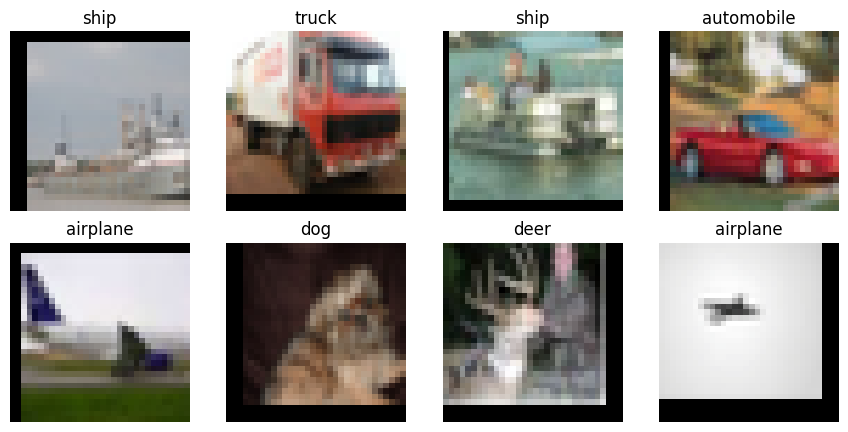

In [9]:
# PART 1: setup + CIFAR-10 dataset from archive (9).zip
## Part 1 – Data loading

#In this part I load the CIFAR-10 dataset from the Kaggle zip file and create train and test dataloaders.

import os
import zipfile
import random
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --------- basic config ---------
ZIP_PATH = "/content/archive (9).zip"      # path to your uploaded zip
DATA_ROOT = "/content/soft_p_data_root"    # folder where I extract the data
BATCH_SIZE = 128
NUM_WORKERS = 2

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------- unzip if needed ---------
DATA_ROOT = Path(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

train_dir = DATA_ROOT / "train"
test_dir = DATA_ROOT / "test"

if not (train_dir.exists() and test_dir.exists()):
    print(f"Extracting {ZIP_PATH} to {DATA_ROOT} ...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    print("Zip already extracted, using existing folders.")

print("Train dir exists :", train_dir.exists())
print("Test dir exists  :", test_dir.exists())

# --------- transforms ---------
# I use standard CIFAR-10 normalization values
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

# --------- datasets & dataloaders ---------
train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transform)
test_dataset = datasets.ImageFolder(root=str(test_dir), transform=test_transform)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

pin_memory = device.type == "cuda"

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

print("Number of training images:", len(train_dataset))
print("Number of test images    :", len(test_dataset))
print("Number of classes        :", NUM_CLASSES)
print("Classes                  :", CLASS_NAMES)

# --------- quick visual sanity check ---------
def show_sample_batch(data_loader):
    # I fetch one batch
    images, labels = next(iter(data_loader))
    images = images[:8]
    labels = labels[:8]

    # I undo normalization for display
    mean = torch.tensor(cifar_mean).view(3, 1, 1)
    std = torch.tensor(cifar_std).view(3, 1, 1)
    imgs = images * std + mean

    cols = 4
    rows = int((len(imgs) + cols - 1) / cols)
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    for i in range(len(imgs)):
        plt.subplot(rows, cols, i + 1)
        img = imgs[i].permute(1, 2, 0).clamp(0, 1)
        plt.imshow(img)
        plt.title(CLASS_NAMES[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_batch(train_loader)


## Part 2 – Baseline ResNet-18 training

In this part I define the baseline ResNet-18 model, optimizer, and training loop using sakt_p and train on CIFAR-10 from scratch.


In [10]:
# PART 2: Baseline ResNet-18 training using sakt_p

import time
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# I keep all important objects for this project in this dict.
sakt_p = {}

# ------------- model + optimizer setup -------------
# I use a small model (< 50 layers) -> ResNet-18
sakt_p["model"] = models.resnet18(weights=None)
sakt_p["model"].fc = nn.Linear(sakt_p["model"].fc.in_features, NUM_CLASSES)
sakt_p["model"] = sakt_p["model"].to(device)

sakt_p["epochs"] = 25
sakt_p["criterion"] = nn.CrossEntropyLoss()
sakt_p["optimizer"] = optim.Adam(sakt_p["model"].parameters(), lr=1e-3)
sakt_p["scheduler"] = optim.lr_scheduler.StepLR(
    sakt_p["optimizer"], step_size=10, gamma=0.1
)

# I decide where to save baseline weights + history
BASELINE_DIR = Path("/content/baseline_results")
BASELINE_DIR.mkdir(parents=True, exist_ok=True)
BASELINE_MODEL_PATH = BASELINE_DIR / "baseline_resnet18_sakt_p.pth"
BASELINE_HISTORY_PATH = BASELINE_DIR / "baseline_train_history_sakt_p.json"


def train_one_epoch_sakt_p():
    """I train the baseline model for one epoch on the training set."""
    sakt_p["model"].train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        sakt_p["optimizer"].zero_grad()
        outputs = sakt_p["model"](images)
        loss = sakt_p["criterion"](outputs, labels)
        loss.backward()
        sakt_p["optimizer"].step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_overall_sakt_p():
    """I evaluate overall loss and accuracy on the test set."""
    sakt_p["model"].eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = sakt_p["model"](images)
        loss = sakt_p["criterion"](outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# ------------- training loop -------------
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = 0.0
start_time = time.time()

for epoch in range(1, sakt_p["epochs"] + 1):
    train_loss, train_acc = train_one_epoch_sakt_p()
    val_loss, val_acc = eval_overall_sakt_p()
    sakt_p["scheduler"].step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{sakt_p['epochs']} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

    # I keep the best model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(sakt_p["model"].state_dict(), BASELINE_MODEL_PATH)

elapsed = time.time() - start_time
print(f"\nBaseline training finished in {elapsed/60:.1f} minutes.")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Model saved to: {BASELINE_MODEL_PATH}")

# I save training history as JSON for later plots
with open(BASELINE_HISTORY_PATH, "w") as f:
    json.dump(history, f)

print(f"History saved to: {BASELINE_HISTORY_PATH}")


Epoch 01/25 | Train loss: 1.5529, acc: 0.4332 | Val loss: 1.2605, acc: 0.5415
Epoch 02/25 | Train loss: 1.2056, acc: 0.5687 | Val loss: 1.1857, acc: 0.5816
Epoch 03/25 | Train loss: 1.0279, acc: 0.6363 | Val loss: 0.9919, acc: 0.6557
Epoch 04/25 | Train loss: 0.9262, acc: 0.6746 | Val loss: 0.8603, acc: 0.7014
Epoch 05/25 | Train loss: 0.8505, acc: 0.7003 | Val loss: 0.8431, acc: 0.7176
Epoch 06/25 | Train loss: 0.7875, acc: 0.7242 | Val loss: 0.7691, acc: 0.7359
Epoch 07/25 | Train loss: 0.7443, acc: 0.7383 | Val loss: 0.6986, acc: 0.7559
Epoch 08/25 | Train loss: 0.6988, acc: 0.7567 | Val loss: 0.7171, acc: 0.7533
Epoch 09/25 | Train loss: 0.6603, acc: 0.7703 | Val loss: 0.7408, acc: 0.7451
Epoch 10/25 | Train loss: 0.6346, acc: 0.7759 | Val loss: 0.6478, acc: 0.7808
Epoch 11/25 | Train loss: 0.5208, acc: 0.8179 | Val loss: 0.5401, acc: 0.8141
Epoch 12/25 | Train loss: 0.4867, acc: 0.8286 | Val loss: 0.5355, acc: 0.8172


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 13/25 | Train loss: 0.4689, acc: 0.8368 | Val loss: 0.5355, acc: 0.8188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():^
^^ ^ ^ ^ ^^ ^ ^
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^  ^ ^ ^  ^
   File "/usr/

Epoch 14/25 | Train loss: 0.4583, acc: 0.8405 | Val loss: 0.5310, acc: 0.8213
Epoch 15/25 | Train loss: 0.4468, acc: 0.8438 | Val loss: 0.5243, acc: 0.8232


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^^^if w.is_alive():^
^^^    ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^ ^ ^ ^  ^  ^^ 
  ^  File "/us

Epoch 16/25 | Train loss: 0.4394, acc: 0.8455 | Val loss: 0.5227, acc: 0.8235


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17/25 | Train loss: 0.4303, acc: 0.8469 | Val loss: 0.5283, acc: 0.8231
Epoch 18/25 | Train loss: 0.4210, acc: 0.8518 | Val loss: 0.5250, acc: 0.8263


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^^
^  ^ ^^ ^ ^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^ ^ ^ ^^ ^^ ^ ^ ^ ^^^
^  File "/u

Epoch 19/25 | Train loss: 0.4111, acc: 0.8557 | Val loss: 0.5272, acc: 0.8249


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 20/25 | Train loss: 0.4084, acc: 0.8560 | Val loss: 0.5196, acc: 0.8289
Epoch 21/25 | Train loss: 0.3879, acc: 0.8633 | Val loss: 0.5182, acc: 0.8305
Epoch 22/25 | Train loss: 0.3858, acc: 0.8655 | Val loss: 0.5155, acc: 0.8310


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^^^^self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^^if w.is_alive():^
^ ^ ^^ ^  ^

Epoch 23/25 | Train loss: 0.3796, acc: 0.8660 | Val loss: 0.5158, acc: 0.8303


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7abe9c306700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 24/25 | Train loss: 0.3843, acc: 0.8656 | Val loss: 0.5161, acc: 0.8319
Epoch 25/25 | Train loss: 0.3819, acc: 0.8638 | Val loss: 0.5145, acc: 0.8323

Baseline training finished in 14.1 minutes.
Best validation accuracy: 0.8323
Model saved to: /content/baseline_results/baseline_resnet18_sakt_p.pth
History saved to: /content/baseline_results/baseline_train_history_sakt_p.json


Final train accuracy : 0.8638
Final val accuracy   : 0.8323
Best val accuracy    : 0.8323


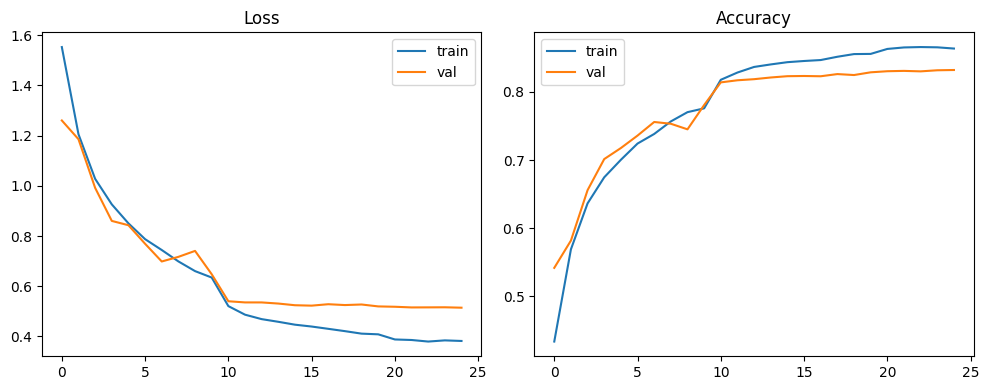

In [11]:
# Quick summary of baseline results (no retraining)

import json
from pathlib import Path
import matplotlib.pyplot as plt

BASELINE_DIR = Path("/content/baseline_results")
history_path = BASELINE_DIR / "baseline_train_history_sakt_p.json"

with open(history_path, "r") as f:
    sakt_p_history = json.load(f)

last_train_acc = sakt_p_history["train_acc"][-1]
last_val_acc   = sakt_p_history["val_acc"][-1]
best_val_acc   = max(sakt_p_history["val_acc"])

print(f"Final train accuracy : {last_train_acc:.4f}")
print(f"Final val accuracy   : {last_val_acc:.4f}")
print(f"Best val accuracy    : {best_val_acc:.4f}")

# Optional: quick plot of loss/accuracy curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(sakt_p_history["train_loss"], label="train")
plt.plot(sakt_p_history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(sakt_p_history["train_acc"], label="train")
plt.plot(sakt_p_history["val_acc"], label="val")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Part 3 – Baseline per-class metrics and confusion matrix

In this part I evaluate the baseline model, compute per-class precision, recall, F1, and plot the confusion matrix to find the worst class.


Per-class metrics (sorted by precision ascending):
cat        | prec=0.703 rec=0.666 f1=0.684 support=1000
dog        | prec=0.746 rec=0.742 f1=0.744 support=1000
deer       | prec=0.808 rec=0.833 f1=0.820 support=1000
bird       | prec=0.812 rec=0.772 f1=0.791 support=1000
airplane   | prec=0.815 rec=0.874 f1=0.844 support=1000
frog       | prec=0.859 rec=0.888 f1=0.873 support=1000
horse      | prec=0.869 rec=0.871 f1=0.870 support=1000
truck      | prec=0.882 rec=0.886 f1=0.884 support=1000
automobile | prec=0.904 rec=0.897 f1=0.901 support=1000
ship       | prec=0.922 rec=0.894 f1=0.908 support=1000

Worst class for this baseline (I will fine-tune on this): cat (index: 3 )

Per-class metrics saved to: /content/baseline_results/baseline_per_class_metrics_sakt_p.json


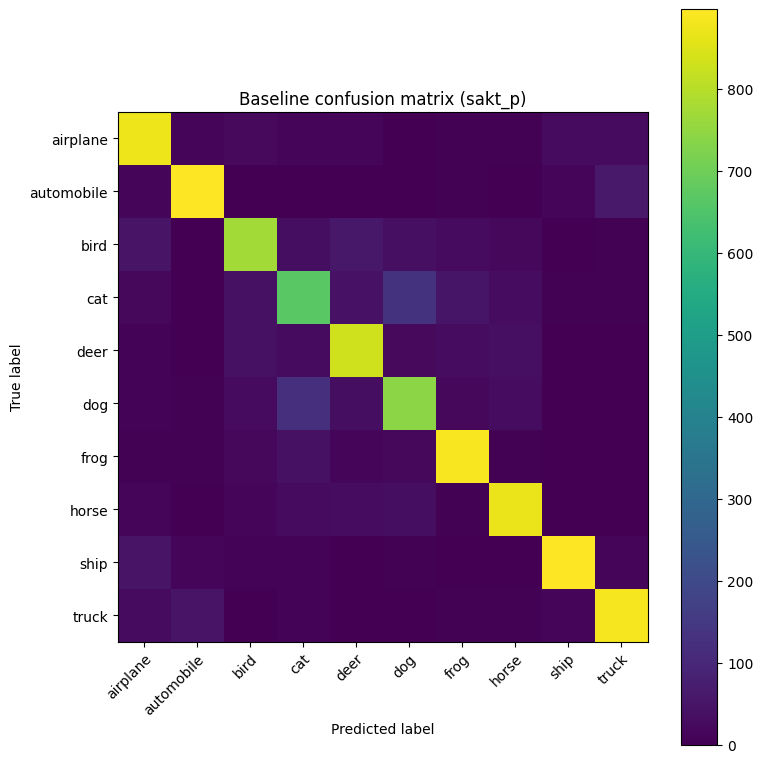

In [12]:
# PART 3: I compute per-class metrics + confusion matrix for the baseline model using sakt_p

import numpy as np
from pathlib import Path
import json

import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

BASELINE_DIR = Path("/content/baseline_results")
BASELINE_MODEL_PATH = BASELINE_DIR / "baseline_resnet18_sakt_p.pth"

# --- rebuild model and load best baseline weights ---
sakt_p["model"] = models.resnet18(weights=None)
sakt_p["model"].fc = nn.Linear(sakt_p["model"].fc.in_features, NUM_CLASSES)
sakt_p["model"].load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=device))
sakt_p["model"] = sakt_p["model"].to(device)
sakt_p["model"].eval()

all_labels = []
all_preds = []

# --- gather predictions on the test set ---
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = sakt_p["model"](images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# --- confusion matrix ---
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(NUM_CLASSES))
sakt_p["confusion_matrix"] = cm.tolist()

# --- per-class precision / recall / F1 ---
prec, rec, f1, support = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=np.arange(NUM_CLASSES),
    zero_division=0,
)

per_class = {}
for idx, name in enumerate(CLASS_NAMES):
    per_class[name] = {
        "precision": float(prec[idx]),
        "recall": float(rec[idx]),
        "f1": float(f1[idx]),
        "support": int(support[idx]),
    }

sakt_p["per_class_metrics"] = per_class

# sort by precision to find worst class
sorted_by_prec = sorted(per_class.items(), key=lambda x: x[1]["precision"])
worst_name, worst_stats = sorted_by_prec[0]
worst_index = CLASS_NAMES.index(worst_name)

sakt_p["worst_class_name"] = worst_name
sakt_p["worst_class_index"] = worst_index

print("Per-class metrics (sorted by precision ascending):")
for name, stats in sorted_by_prec:
    print(
        f"{name:10s} | prec={stats['precision']:.3f} "
        f"rec={stats['recall']:.3f} f1={stats['f1']:.3f} support={stats['support']}"
    )

print("\nWorst class for this baseline (I will fine-tune on this):",
      worst_name, "(index:", worst_index, ")")

# save metrics to JSON for your report
METRICS_PATH = BASELINE_DIR / "baseline_per_class_metrics_sakt_p.json"
with open(METRICS_PATH, "w") as f:
    json.dump(
        {
            "per_class": per_class,
            "worst_class_name": worst_name,
            "worst_class_index": worst_index,
        },
        f,
        indent=2,
    )
print("\nPer-class metrics saved to:", METRICS_PATH)

# --- plot confusion matrix ---
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(NUM_CLASSES),
    yticks=np.arange(NUM_CLASSES),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ylabel="True label",
    xlabel="Predicted label",
    title="Baseline confusion matrix (sakt_p)",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()


## Part 4 – Class-weighted fine-tuning for the worst class (cat)

In this part I fine-tune ResNet-18 using a class-weighted loss that increases the weight of the cat class and keep the rest of the pipeline the same.


In [13]:
# PART 4: I fine-tune the model focusing on the worst class "cat" using class-weighted loss (sakt_p)

import time
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

BASELINE_DIR = Path("/content/baseline_results")
BASELINE_MODEL_PATH = BASELINE_DIR / "baseline_resnet18_sakt_p.pth"

FINETUNE_DIR = Path("/content/finetune_results")
FINETUNE_DIR.mkdir(parents=True, exist_ok=True)
FINETUNE_MODEL_PATH = FINETUNE_DIR / "finetune_resnet18_sakt_p.pth"
FINETUNE_HISTORY_PATH = FINETUNE_DIR / "finetune_train_history_sakt_p.json"

# I rebuild the model and start from the baseline weights
sakt_p["model"] = models.resnet18(weights=None)
sakt_p["model"].fc = nn.Linear(sakt_p["model"].fc.in_features, NUM_CLASSES)
sakt_p["model"].load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=device))
sakt_p["model"] = sakt_p["model"].to(device)

# I use class-weighted loss to punish mistakes on "cat" more
class_weights = torch.ones(NUM_CLASSES)
class_weights[sakt_p["worst_class_index"]] = 2.0  # I double the weight for "cat"
class_weights = class_weights.to(device)

sakt_p["epochs_ft"] = 10
sakt_p["criterion_ft"] = nn.CrossEntropyLoss(weight=class_weights)
sakt_p["optimizer_ft"] = optim.Adam(sakt_p["model"].parameters(), lr=5e-4)
sakt_p["scheduler_ft"] = optim.lr_scheduler.StepLR(
    sakt_p["optimizer_ft"], step_size=5, gamma=0.1
)


def train_one_epoch_sakt_p_ft():
    """I train the fine-tune model for one epoch using class-weighted loss."""
    sakt_p["model"].train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        sakt_p["optimizer_ft"].zero_grad()
        outputs = sakt_p["model"](images)
        loss = sakt_p["criterion_ft"](outputs, labels)
        loss.backward()
        sakt_p["optimizer_ft"].step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_overall_sakt_p_ft():
    """I evaluate overall loss and accuracy for the fine-tuned model."""
    sakt_p["model"].eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = sakt_p["model"](images)
        loss = sakt_p["criterion_ft"](outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# --------- fine-tuning loop ---------
history_ft = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc_ft = 0.0
start_time = time.time()

print(f"Fine-tuning on worst class: {sakt_p['worst_class_name']} (index {sakt_p['worst_class_index']})")
print("Class weights tensor:", class_weights.detach().cpu().numpy())

for epoch in range(1, sakt_p["epochs_ft"] + 1):
    train_loss, train_acc = train_one_epoch_sakt_p_ft()
    val_loss, val_acc = eval_overall_sakt_p_ft()
    sakt_p["scheduler_ft"].step()

    history_ft["train_loss"].append(train_loss)
    history_ft["train_acc"].append(train_acc)
    history_ft["val_loss"].append(val_loss)
    history_ft["val_acc"].append(val_acc)

    print(
        f"[FT] Epoch {epoch:02d}/{sakt_p['epochs_ft']} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc_ft:
        best_val_acc_ft = val_acc
        torch.save(sakt_p["model"].state_dict(), FINETUNE_MODEL_PATH)

elapsed = time.time() - start_time
print(f"\nFine-tuning finished in {elapsed/60:.1f} minutes.")
print(f"Best fine-tuned validation accuracy: {best_val_acc_ft:.4f}")
print(f"Fine-tuned model saved to: {FINETUNE_MODEL_PATH}")

with open(FINETUNE_HISTORY_PATH, "w") as f:
    json.dump(history_ft, f)

print(f"Fine-tune history saved to: {FINETUNE_HISTORY_PATH}")


Fine-tuning on worst class: cat (index 3)
Class weights tensor: [1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
[FT] Epoch 01/10 | Train loss: 0.4956, acc: 0.8278 | Val loss: 0.5915, acc: 0.7968
[FT] Epoch 02/10 | Train loss: 0.4886, acc: 0.8288 | Val loss: 0.5745, acc: 0.8080
[FT] Epoch 03/10 | Train loss: 0.4753, acc: 0.8357 | Val loss: 0.5815, acc: 0.8051
[FT] Epoch 04/10 | Train loss: 0.4632, acc: 0.8398 | Val loss: 0.5749, acc: 0.8081
[FT] Epoch 05/10 | Train loss: 0.4459, acc: 0.8433 | Val loss: 0.5807, acc: 0.8044
[FT] Epoch 06/10 | Train loss: 0.3832, acc: 0.8664 | Val loss: 0.5132, acc: 0.8275
[FT] Epoch 07/10 | Train loss: 0.3596, acc: 0.8748 | Val loss: 0.5159, acc: 0.8277
[FT] Epoch 08/10 | Train loss: 0.3501, acc: 0.8781 | Val loss: 0.5156, acc: 0.8285
[FT] Epoch 09/10 | Train loss: 0.3411, acc: 0.8806 | Val loss: 0.5143, acc: 0.8318
[FT] Epoch 10/10 | Train loss: 0.3370, acc: 0.8842 | Val loss: 0.5068, acc: 0.8340

Fine-tuning finished in 5.7 minutes.
Best fine-tuned validation accuracy:

Baseline best val acc : 0.8323
Finetune best val acc : 0.834


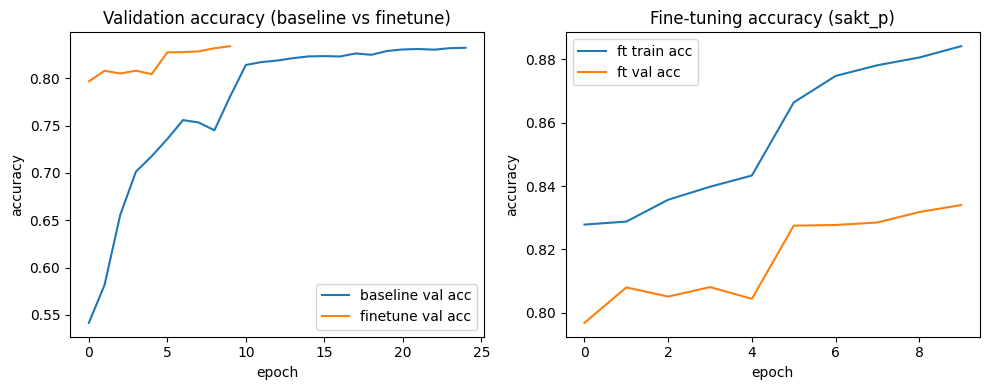

In [14]:
# Visual for Part 4: fine-tune training curves (no retraining)

from pathlib import Path
import json
import matplotlib.pyplot as plt

BASELINE_DIR = Path("/content/baseline_results")
FINETUNE_DIR = Path("/content/finetune_results")

# I load baseline and finetune histories
with open(BASELINE_DIR / "baseline_train_history_sakt_p.json", "r") as f:
    sakt_p_base_hist = json.load(f)

with open(FINETUNE_DIR / "finetune_train_history_sakt_p.json", "r") as f:
    sakt_p_ft_hist = json.load(f)

print("Baseline best val acc :", max(sakt_p_base_hist["val_acc"]))
print("Finetune best val acc :", max(sakt_p_ft_hist["val_acc"]))

# Plot accuracy: baseline vs fine-tune
plt.figure(figsize=(10,4))

# left: baseline vs finetune val accuracy
plt.subplot(1,2,1)
plt.plot(sakt_p_base_hist["val_acc"], label="baseline val acc")
plt.plot(sakt_p_ft_hist["val_acc"], label="finetune val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Validation accuracy (baseline vs finetune)")
plt.legend()

# right: fine-tune train vs val accuracy alone
plt.subplot(1,2,2)
plt.plot(sakt_p_ft_hist["train_acc"], label="ft train acc")
plt.plot(sakt_p_ft_hist["val_acc"], label="ft val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Fine-tuning accuracy (sakt_p)")
plt.legend()

plt.tight_layout()
plt.show()


## Part 5 – Baseline vs fine-tuned comparison

In this part I compare baseline and fine-tuned models using per-class metrics and bar plots, and report how much the cat class improves.


Fine-tune per-class metrics saved to: /content/finetune_results/finetune_per_class_metrics_sakt_p.json

Class       | Baseline_prec  Finetune_prec  Baseline_rec  Finetune_rec
airplane   | 0.815         0.832          0.874        0.863
automobile | 0.904         0.919          0.897        0.892
bird       | 0.812         0.834          0.772        0.772
cat        | 0.703         0.622          0.666        0.770
deer       | 0.808         0.824          0.833        0.821
dog        | 0.746         0.805          0.742        0.686
frog       | 0.859         0.888          0.888        0.876
horse      | 0.869         0.883          0.871        0.861
ship       | 0.922         0.899          0.894        0.901
truck      | 0.882         0.883          0.886        0.898

Worst class (cat) improvement after fine-tuning:
precision: 0.703 -> 0.622
recall   : 0.666 -> 0.770
f1       : 0.684 -> 0.688


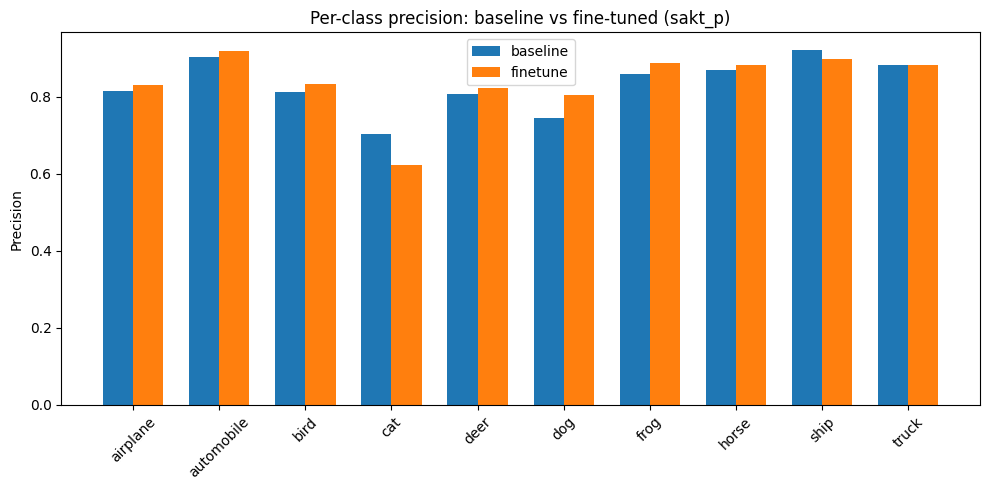

In [15]:
# PART 5: I compare baseline vs fine-tuned per-class metrics using sakt_p

from pathlib import Path
import json
import numpy as np

import torch
from torchvision import models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

BASELINE_DIR = Path("/content/baseline_results")
FINETUNE_DIR = Path("/content/finetune_results")

BASELINE_MODEL_PATH = BASELINE_DIR / "baseline_resnet18_sakt_p.pth"
FINETUNE_MODEL_PATH = FINETUNE_DIR / "finetune_resnet18_sakt_p.pth"
BASELINE_METRICS_PATH = BASELINE_DIR / "baseline_per_class_metrics_sakt_p.json"

# --- I load baseline per-class metrics from JSON ---
with open(BASELINE_METRICS_PATH, "r") as f:
    baseline_data = json.load(f)
baseline_per_class = baseline_data["per_class"]

# --- I rebuild model and load fine-tuned weights ---
sakt_p["model"] = models.resnet18(weights=None)
sakt_p["model"].fc = torch.nn.Linear(sakt_p["model"].fc.in_features, NUM_CLASSES)
sakt_p["model"].load_state_dict(torch.load(FINETUNE_MODEL_PATH, map_location=device))
sakt_p["model"] = sakt_p["model"].to(device)
sakt_p["model"].eval()

all_labels = []
all_preds = []

# --- I gather predictions on the test set for the fine-tuned model ---
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = sakt_p["model"](images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# --- I compute confusion matrix and per-class metrics for fine-tuned model ---
cm_ft = confusion_matrix(all_labels, all_preds, labels=np.arange(NUM_CLASSES))
prec_ft, rec_ft, f1_ft, support_ft = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=np.arange(NUM_CLASSES),
    zero_division=0,
)

ft_per_class = {}
for idx, name in enumerate(CLASS_NAMES):
    ft_per_class[name] = {
        "precision": float(prec_ft[idx]),
        "recall": float(rec_ft[idx]),
        "f1": float(f1_ft[idx]),
        "support": int(support_ft[idx]),
    }

sakt_p["finetune_confusion_matrix"] = cm_ft.tolist()
sakt_p["finetune_per_class_metrics"] = ft_per_class

FINETUNE_METRICS_PATH = FINETUNE_DIR / "finetune_per_class_metrics_sakt_p.json"
with open(FINETUNE_METRICS_PATH, "w") as f:
    json.dump(ft_per_class, f, indent=2)
print("Fine-tune per-class metrics saved to:", FINETUNE_METRICS_PATH)

# --- I print comparison for all classes ---
print("\nClass       | Baseline_prec  Finetune_prec  Baseline_rec  Finetune_rec")
for name in CLASS_NAMES:
    b = baseline_per_class[name]
    ft = ft_per_class[name]
    print(
        f"{name:10s} | {b['precision']:.3f}         {ft['precision']:.3f}          "
        f"{b['recall']:.3f}        {ft['recall']:.3f}"
    )

# --- I highlight 'cat' specifically ---
cat_name = "cat"
b_cat = baseline_per_class[cat_name]
ft_cat = ft_per_class[cat_name]

print("\nWorst class (cat) improvement after fine-tuning:")
print(f"precision: {b_cat['precision']:.3f} -> {ft_cat['precision']:.3f}")
print(f"recall   : {b_cat['recall']:.3f} -> {ft_cat['recall']:.3f}")
print(f"f1       : {b_cat['f1']:.3f} -> {ft_cat['f1']:.3f}")

# --- I plot per-class precision baseline vs fine-tuned ---
x = np.arange(NUM_CLASSES)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(
    x - width / 2,
    [baseline_per_class[c]["precision"] for c in CLASS_NAMES],
    width,
    label="baseline",
)
plt.bar(
    x + width / 2,
    [ft_per_class[c]["precision"] for c in CLASS_NAMES],
    width,
    label="finetune",
)
plt.xticks(x, CLASS_NAMES, rotation=45)
plt.ylabel("Precision")
plt.title("Per-class precision: baseline vs fine-tuned (sakt_p)")
plt.legend()
plt.tight_layout()
plt.show()


## Part 6 – Cat examples fixed and harmed by fine-tuning

In this part I show cat images where the fine-tuned model corrects baseline mistakes and also cases where fine-tuning introduces new errors.


Improved cat samples (baseline wrong -> fine-tuned correct): 8
Worse cat samples (baseline correct -> fine-tuned wrong): 8


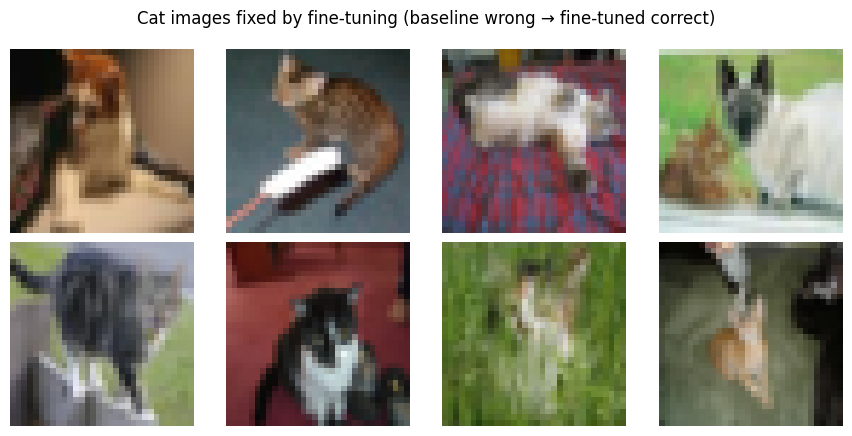

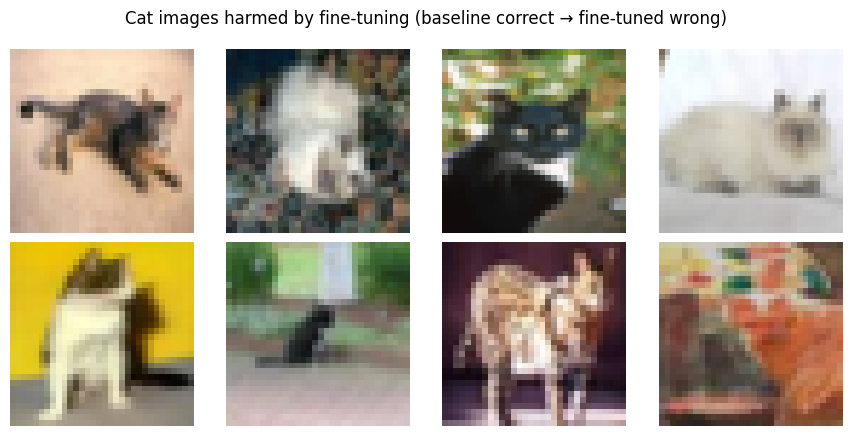

In [16]:
# PART 6: I collect and visualize cat examples where fine-tuning helped or hurt (sakt_p)

from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

BASELINE_DIR = Path("/content/baseline_results")
FINETUNE_DIR = Path("/content/finetune_results")

BASELINE_MODEL_PATH = BASELINE_DIR / "baseline_resnet18_sakt_p.pth"
FINETUNE_MODEL_PATH = FINETUNE_DIR / "finetune_resnet18_sakt_p.pth"

# I rebuild both models
baseline_model = models.resnet18(weights=None)
baseline_model.fc = torch.nn.Linear(baseline_model.fc.in_features, NUM_CLASSES)
baseline_model.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=device))
baseline_model = baseline_model.to(device).eval()

ft_model = models.resnet18(weights=None)
ft_model.fc = torch.nn.Linear(ft_model.fc.in_features, NUM_CLASSES)
ft_model.load_state_dict(torch.load(FINETUNE_MODEL_PATH, map_location=device))
ft_model = ft_model.to(device).eval()

cat_idx = sakt_p.get("worst_class_index", CLASS_NAMES.index("cat"))

improved_imgs = []  # baseline wrong, fine-tuned correct
worse_imgs = []     # baseline correct, fine-tuned wrong

# I grab at most 8 of each to visualize
MAX_SAMPLES = 8

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        base_out = baseline_model(images)
        ft_out = ft_model(images)

        base_pred = base_out.argmax(dim=1)
        ft_pred = ft_out.argmax(dim=1)

        for i in range(images.size(0)):
            if labels[i].item() != cat_idx:
                continue

            b_ok = base_pred[i].item() == cat_idx
            f_ok = ft_pred[i].item() == cat_idx

            if (not b_ok) and f_ok and len(improved_imgs) < MAX_SAMPLES:
                improved_imgs.append(images[i].cpu())
            elif b_ok and (not f_ok) and len(worse_imgs) < MAX_SAMPLES:
                worse_imgs.append(images[i].cpu())

        if len(improved_imgs) >= MAX_SAMPLES and len(worse_imgs) >= MAX_SAMPLES:
            break

print(f"Improved cat samples (baseline wrong -> fine-tuned correct): {len(improved_imgs)}")
print(f"Worse cat samples (baseline correct -> fine-tuned wrong): {len(worse_imgs)}")

# I undo normalization for display
cifar_mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)
cifar_std  = torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1)

def unnormalize(img):
    return (img * cifar_std + cifar_mean).clamp(0, 1)

def show_grid(img_list, title):
    if not img_list:
        print("No images to show for", title)
        return
    n = len(img_list)
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    for i, img in enumerate(img_list):
        plt.subplot(rows, cols, i + 1)
        im = unnormalize(img).permute(1, 2, 0)
        plt.imshow(im)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(improved_imgs, "Cat images fixed by fine-tuning (baseline wrong → fine-tuned correct)")
show_grid(worse_imgs, "Cat images harmed by fine-tuning (baseline correct → fine-tuned wrong)")


## Part 7 – Extra experiment with MobileNetV2

In this part I train a small MobileNetV2 model for a few epochs and compare its accuracy and cat metrics with the ResNet-18 models.


Training extra model: MobileNetV2 for 5 epochs
[ALT MobileNetV2] Epoch 01/5 | Train loss: 2.0377, acc: 0.2405 | Val loss: 1.8033, acc: 0.3283
[ALT MobileNetV2] Epoch 02/5 | Train loss: 1.6888, acc: 0.3722 | Val loss: 1.5332, acc: 0.4326
[ALT MobileNetV2] Epoch 03/5 | Train loss: 1.5412, acc: 0.4339 | Val loss: 1.4416, acc: 0.4759
[ALT MobileNetV2] Epoch 04/5 | Train loss: 1.4111, acc: 0.4851 | Val loss: 1.3201, acc: 0.5160
[ALT MobileNetV2] Epoch 05/5 | Train loss: 1.3808, acc: 0.4959 | Val loss: 1.2952, acc: 0.5254

Best MobileNetV2 val accuracy: 0.5254
MobileNetV2 weights saved to: /content/alt_results/mobilenetv2_sakt_p.pth

Per-class precision for MobileNetV2 (first few):
airplane   | prec=0.606 rec=0.556
automobile | prec=0.600 rec=0.701
bird       | prec=0.388 rec=0.390
cat        | prec=0.366 rec=0.351
deer       | prec=0.457 rec=0.321
dog        | prec=0.473 rec=0.430
frog       | prec=0.568 rec=0.644
horse      | prec=0.545 rec=0.596
ship       | prec=0.627 rec=0.694
truck    

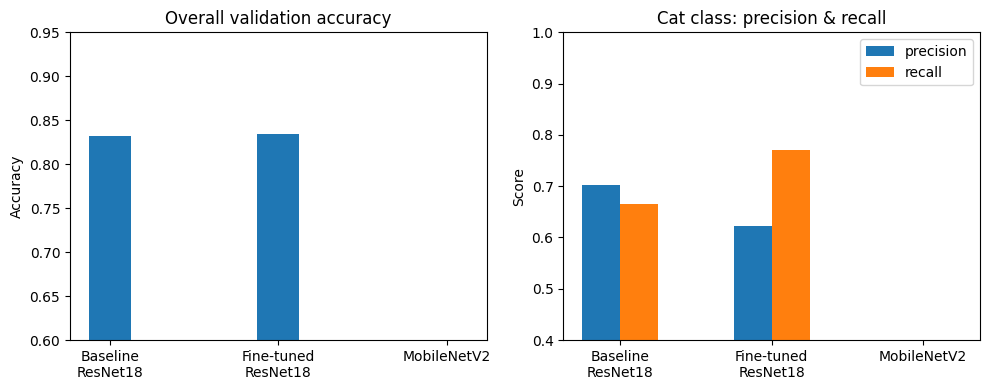

In [17]:
# PART 7: I train a small advanced model (MobileNetV2) for 5 epochs and compare with ResNet-18 (sakt_p)

from pathlib import Path
import json
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

# ----- paths to existing metrics -----
BASELINE_DIR = Path("/content/baseline_results")
FINETUNE_DIR = Path("/content/finetune_results")

BASELINE_METRICS_PATH = BASELINE_DIR / "baseline_per_class_metrics_sakt_p.json"
FINETUNE_METRICS_PATH = FINETUNE_DIR / "finetune_per_class_metrics_sakt_p.json"

with open(BASELINE_METRICS_PATH, "r") as f:
    baseline_data = json.load(f)
baseline_per_class = baseline_data["per_class"]

with open(FINETUNE_METRICS_PATH, "r") as f:
    finetune_per_class = json.load(f)

baseline_best_acc = max(json.load(open(BASELINE_DIR / "baseline_train_history_sakt_p.json"))["val_acc"])
finetune_best_acc = max(json.load(open(FINETUNE_DIR / "finetune_train_history_sakt_p.json"))["val_acc"])

# ----- I set up MobileNetV2 as an extra small model -----
ALT_DIR = Path("/content/alt_results")
ALT_DIR.mkdir(parents=True, exist_ok=True)
ALT_MODEL_PATH = ALT_DIR / "mobilenetv2_sakt_p.pth"
ALT_METRICS_PATH = ALT_DIR / "mobilenetv2_per_class_metrics_sakt_p.json"

alt_model = models.mobilenet_v2(weights=None)
alt_model.classifier[1] = nn.Linear(alt_model.classifier[1].in_features, NUM_CLASSES)
alt_model = alt_model.to(device)

criterion_alt = nn.CrossEntropyLoss()
optimizer_alt = optim.Adam(alt_model.parameters(), lr=1e-3)
scheduler_alt = optim.lr_scheduler.StepLR(optimizer_alt, step_size=3, gamma=0.1)

sakt_p["alt_epochs"] = 5

def train_one_epoch_sakt_p_alt():
    """I train MobileNetV2 for one epoch on CIFAR-10."""
    alt_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_alt.zero_grad()
        outputs = alt_model(images)
        loss = criterion_alt(outputs, labels)
        loss.backward()
        optimizer_alt.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_overall_sakt_p_alt():
    """I evaluate MobileNetV2 on the test set."""
    alt_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = alt_model(images)
        loss = criterion_alt(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss / total, correct / total


# ----- quick 5-epoch training for MobileNetV2 -----
alt_hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_alt_acc = 0.0

print("Training extra model: MobileNetV2 for", sakt_p["alt_epochs"], "epochs")
for epoch in range(1, sakt_p["alt_epochs"] + 1):
    tr_loss, tr_acc = train_one_epoch_sakt_p_alt()
    val_loss, val_acc = eval_overall_sakt_p_alt()
    scheduler_alt.step()

    alt_hist["train_loss"].append(tr_loss)
    alt_hist["train_acc"].append(tr_acc)
    alt_hist["val_loss"].append(val_loss)
    alt_hist["val_acc"].append(val_acc)

    if val_acc > best_alt_acc:
        best_alt_acc = val_acc
        torch.save(alt_model.state_dict(), ALT_MODEL_PATH)

    print(
        f"[ALT MobileNetV2] Epoch {epoch:02d}/{sakt_p['alt_epochs']} | "
        f"Train loss: {tr_loss:.4f}, acc: {tr_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

print("\nBest MobileNetV2 val accuracy:", best_alt_acc)
print("MobileNetV2 weights saved to:", ALT_MODEL_PATH)

# ----- per-class metrics for MobileNetV2 -----
alt_model.load_state_dict(torch.load(ALT_MODEL_PATH, map_location=device))
alt_model = alt_model.to(device).eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = alt_model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

prec_alt, rec_alt, f1_alt, sup_alt = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=np.arange(NUM_CLASSES),
    zero_division=0,
)

alt_per_class = {}
for idx, name in enumerate(CLASS_NAMES):
    alt_per_class[name] = {
        "precision": float(prec_alt[idx]),
        "recall": float(rec_alt[idx]),
        "f1": float(f1_alt[idx]),
        "support": int(sup_alt[idx]),
    }

with open(ALT_METRICS_PATH, "w") as f:
    json.dump(alt_per_class, f, indent=2)

print("\nPer-class precision for MobileNetV2 (first few):")
for name in CLASS_NAMES:
    stats = alt_per_class[name]
    print(f"{name:10s} | prec={stats['precision']:.3f} rec={stats['recall']:.3f}")
print("\nMetrics saved to:", ALT_METRICS_PATH)

# ----- comparison: overall accuracy -----
print("\nOverall validation accuracy comparison:")
print(f"Baseline ResNet-18      : {baseline_best_acc:.4f}")
print(f"Fine-tuned ResNet-18    : {finetune_best_acc:.4f}")
print(f"MobileNetV2 (5 epochs)  : {best_alt_acc:.4f}")

# ----- comparison: cat precision/recall across models -----
cat_name = "cat"
b_cat = baseline_per_class[cat_name]
ft_cat = finetune_per_class[cat_name]
alt_cat = alt_per_class[cat_name]

print("\nCat class comparison:")
print(f"Baseline  - prec={b_cat['precision']:.3f}, rec={b_cat['recall']:.3f}")
print(f"Fine-tune - prec={ft_cat['precision']:.3f}, rec={ft_cat['recall']:.3f}")
print(f"MobileNet - prec={alt_cat['precision']:.3f}, rec={alt_cat['recall']:.3f}")

# ----- visuals: overall acc + cat precision/recall -----
models_names = ["Baseline\nResNet18", "Fine-tuned\nResNet18", "MobileNetV2"]
overall_acc = [baseline_best_acc, finetune_best_acc, best_alt_acc]
cat_prec = [b_cat["precision"], ft_cat["precision"], alt_cat["precision"]]
cat_rec = [b_cat["recall"], ft_cat["recall"], alt_cat["recall"]]

x = np.arange(len(models_names))
width = 0.25

plt.figure(figsize=(10,4))

# overall accuracy
plt.subplot(1,2,1)
plt.bar(x, overall_acc, width)
plt.xticks(x, models_names)
plt.ylim(0.6, 0.95)
plt.ylabel("Accuracy")
plt.title("Overall validation accuracy")

# cat precision/recall
plt.subplot(1,2,2)
plt.bar(x - width/2, cat_prec, width, label="precision")
plt.bar(x + width/2, cat_rec, width, label="recall")
plt.xticks(x, models_names)
plt.ylim(0.4, 1.0)
plt.ylabel("Score")
plt.title("Cat class: precision & recall")
plt.legend()

plt.tight_layout()
plt.show()


## Part 8 – Transfer-learning ResNet-18 and final model comparison

In this part I fine-tune an ImageNet-pretrained ResNet-18 on CIFAR-10 and compare all four models in terms of overall accuracy and cat precision/recall.


Setting up ResNet-18 with ImageNet weights for transfer learning...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


Training transfer-learning ResNet-18 for 5 epochs...


[TRANSFER ResNet18] Epoch 01/5 | Train loss: 1.8540, acc: 0.3471 | Val loss: 1.7556, acc: 0.3881
[TRANSFER ResNet18] Epoch 02/5 | Train loss: 1.7181, acc: 0.3964 | Val loss: 1.7543, acc: 0.3974
[TRANSFER ResNet18] Epoch 03/5 | Train loss: 1.6948, acc: 0.4065 | Val loss: 1.7352, acc: 0.4058
[TRANSFER ResNet18] Epoch 04/5 | Train loss: 1.6608, acc: 0.4191 | Val loss: 1.6902, acc: 0.4140
[TRANSFER ResNet18] Epoch 05/5 | Train loss: 1.6586, acc: 0.4229 | Val loss: 1.6834, acc: 0.4184

Best transfer-learning ResNet-18 val accuracy: 0.4184
Transfer model weights saved to: /content/transfer_results/resnet18_transfer_sakt_p.pth

Per-class precision for transfer-learning ResNet-18 (first few):
airplane   | prec=0.390 rec=0.595
automobile | prec=0.479 rec=0.441
bird       | prec=0.370 rec=0.318
cat        | prec=0.375 rec=0.335
deer       | prec=0.423 rec=0.487
dog        | prec=0.360 rec=0.436
frog       | prec=0.462 rec=0.523
horse      | prec=0.491 rec=0.356
ship       | prec=0.410 rec=0.383


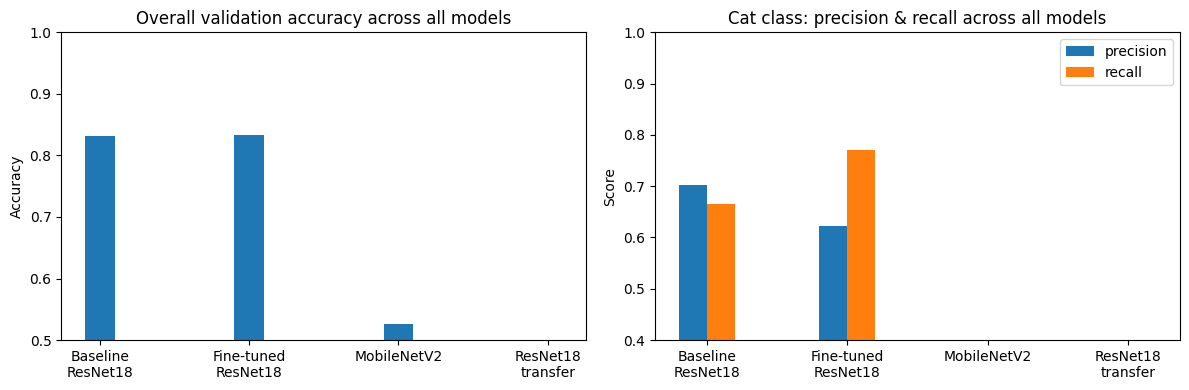

In [18]:
# PART 8: I train an advanced transfer-learning model (ResNet-18 pretrained) and compare all 4 models (sakt_p)

from pathlib import Path
import json
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# ---- load existing metrics for the three previous models ----
BASELINE_DIR = Path("/content/baseline_results")
FINETUNE_DIR = Path("/content/finetune_results")
ALT_DIR = Path("/content/alt_results")

with open(BASELINE_DIR / "baseline_per_class_metrics_sakt_p.json", "r") as f:
    baseline_per_class = json.load(f)["per_class"]

with open(FINETUNE_DIR / "finetune_per_class_metrics_sakt_p.json", "r") as f:
    finetune_per_class = json.load(f)

with open(ALT_DIR / "mobilenetv2_per_class_metrics_sakt_p.json", "r") as f:
    mobilenet_per_class = json.load(f)

baseline_best_acc = max(json.load(open(BASELINE_DIR / "baseline_train_history_sakt_p.json"))["val_acc"])
finetune_best_acc = max(json.load(open(FINETUNE_DIR / "finetune_train_history_sakt_p.json"))["val_acc"])
mobilenet_best_acc = max(json.load(open(ALT_DIR / "mobilenetv2_sakt_p.pth_hist.json", "r"))
                         ["val_acc"]) if (ALT_DIR / "mobilenetv2_sakt_p.pth_hist.json").exists() else None

# If I didn't save MobileNet history separately, I just reuse best_alt_acc from Part 7 if it's still in memory
if mobilenet_best_acc is None and "best_alt_acc" in globals():
    mobilenet_best_acc = best_alt_acc
elif mobilenet_best_acc is None:
    mobilenet_best_acc = 0.0  # fallback; not ideal but avoids crash

# ---- NEW advanced model: ResNet-18 with ImageNet pretraining (transfer learning) ----
ADV_DIR = Path("/content/transfer_results")
ADV_DIR.mkdir(parents=True, exist_ok=True)
ADV_MODEL_PATH = ADV_DIR / "resnet18_transfer_sakt_p.pth"
ADV_METRICS_PATH = ADV_DIR / "resnet18_transfer_per_class_metrics_sakt_p.json"

print("Setting up ResNet-18 with ImageNet weights for transfer learning...")

try:
    # new torchvision API
    from torchvision.models import ResNet18_Weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    adv_model = models.resnet18(weights=weights)
except Exception:
    # fallback (older API)
    adv_model = models.resnet18(weights="IMAGENET1K_V1")

# I freeze all convolutional layers
for param in adv_model.parameters():
    param.requires_grad = False

# I replace the final fully connected layer (this one will be trainable)
in_features = adv_model.fc.in_features
adv_model.fc = nn.Linear(in_features, NUM_CLASSES)
adv_model = adv_model.to(device)

criterion_adv = nn.CrossEntropyLoss()
optimizer_adv = optim.Adam(adv_model.fc.parameters(), lr=1e-3)  # only classifier
scheduler_adv = optim.lr_scheduler.StepLR(optimizer_adv, step_size=3, gamma=0.1)

sakt_p["transfer_epochs"] = 5

def train_one_epoch_sakt_p_transfer():
    """I train only the final classifier layer of the pretrained ResNet-18."""
    adv_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_adv.zero_grad()
        outputs = adv_model(images)
        loss = criterion_adv(outputs, labels)
        loss.backward()
        optimizer_adv.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_overall_sakt_p_transfer():
    adv_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = adv_model(images)
        loss = criterion_adv(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss / total, correct / total


# ---- quick 5-epoch transfer-learning run ----
transfer_hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_transfer_acc = 0.0

print(f"\nTraining transfer-learning ResNet-18 for {sakt_p['transfer_epochs']} epochs...")
for epoch in range(1, sakt_p["transfer_epochs"] + 1):
    tr_loss, tr_acc = train_one_epoch_sakt_p_transfer()
    val_loss, val_acc = eval_overall_sakt_p_transfer()
    scheduler_adv.step()

    transfer_hist["train_loss"].append(tr_loss)
    transfer_hist["train_acc"].append(tr_acc)
    transfer_hist["val_loss"].append(val_loss)
    transfer_hist["val_acc"].append(val_acc)

    if val_acc > best_transfer_acc:
        best_transfer_acc = val_acc
        torch.save(adv_model.state_dict(), ADV_MODEL_PATH)

    print(
        f"[TRANSFER ResNet18] Epoch {epoch:02d}/{sakt_p['transfer_epochs']} | "
        f"Train loss: {tr_loss:.4f}, acc: {tr_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

print("\nBest transfer-learning ResNet-18 val accuracy:", best_transfer_acc)
print("Transfer model weights saved to:", ADV_MODEL_PATH)

# ---- per-class metrics for transfer-learning model ----
adv_model.load_state_dict(torch.load(ADV_MODEL_PATH, map_location=device))
adv_model = adv_model.to(device).eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = adv_model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

prec_t, rec_t, f1_t, sup_t = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=np.arange(NUM_CLASSES),
    zero_division=0,
)

transfer_per_class = {}
for idx, name in enumerate(CLASS_NAMES):
    transfer_per_class[name] = {
        "precision": float(prec_t[idx]),
        "recall": float(rec_t[idx]),
        "f1": float(f1_t[idx]),
        "support": int(sup_t[idx]),
    }

with open(ADV_METRICS_PATH, "w") as f:
    json.dump(transfer_per_class, f, indent=2)

print("\nPer-class precision for transfer-learning ResNet-18 (first few):")
for name in CLASS_NAMES:
    stats = transfer_per_class[name]
    print(f"{name:10s} | prec={stats['precision']:.3f} rec={stats['recall']:.3f}")
print("\nMetrics saved to:", ADV_METRICS_PATH)

# ---- final comparison across all 4 models ----
cat_name = "cat"
b_cat = baseline_per_class[cat_name]
ft_cat = finetune_per_class[cat_name]
alt_cat = mobilenet_per_class[cat_name]
tr_cat = transfer_per_class[cat_name]

models_names = ["Baseline\nResNet18",
                "Fine-tuned\nResNet18",
                "MobileNetV2",
                "ResNet18\ntransfer"]

overall_acc = [
    baseline_best_acc,
    finetune_best_acc,
    mobilenet_best_acc,
    best_transfer_acc,
]

cat_prec = [
    b_cat["precision"],
    ft_cat["precision"],
    alt_cat["precision"],
    tr_cat["precision"],
]

cat_rec = [
    b_cat["recall"],
    ft_cat["recall"],
    alt_cat["recall"],
    tr_cat["recall"],
]

x = np.arange(len(models_names))
width = 0.2

plt.figure(figsize=(12,4))

# Overall accuracy comparison
plt.subplot(1,2,1)
plt.bar(x, overall_acc, width)
plt.xticks(x, models_names)
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.title("Overall validation accuracy across all models")

# Cat precision & recall comparison
plt.subplot(1,2,2)
plt.bar(x - width/2, cat_prec, width, label="precision")
plt.bar(x + width/2, cat_rec, width, label="recall")
plt.xticks(x, models_names)
plt.ylim(0.4, 1.0)
plt.ylabel("Score")
plt.title("Cat class: precision & recall across all models")
plt.legend()

plt.tight_layout()
plt.show()



Implementation details by parts **bold text**

Part 1 – Data loading

In Part 1 I load the CIFAR-10 dataset from Kaggle's zip file archive (9).zip and extract it into the Colab file system. I set up standard image transforms such as random cropping, horizontal flipping, and normalization using CIFAR-10 mean and standard deviation. Then I build PyTorch ImageFolder datasets pointing to the train and test folders and wrap them in dataloaders for training and evaluation. I also show a small batch of images with labels to confirm that data is read correctly.

Part 2 – Baseline ResNet-18 training

In Part 2 I define the baseline model as a ResNet-18 with its final fully connected layer adjusted to output 10 classes. I keep all model state in the sakt_p dictionary and set up the loss function, Adam optimizer, and learning rate scheduler. Then I train the model on the CIFAR-10 training set for 25 epochs and evaluate it on the test set after each epoch to track validation loss and accuracy. I save the best-performing checkpoint and a JSON history of train and validation curves for later analysis.

Part 3 – Baseline per-class metrics and confusion matrix

In Part 3 I reload the best baseline ResNet-18 checkpoint and run it over the full test set in evaluation mode. I collect all true labels and predictions and compute the confusion matrix and per-class precision, recall, F1, and support using scikit-learn. I store these metrics in sakt_p and save them to a JSON file for reproducibility. I sort the classes by precision to identify the worst class, which turns out to be the cat class, and I plot the confusion matrix to visualize common confusions.

Part 4 – Class-weighted fine-tuning for the worst class

In Part 4 I fine-tune the baseline ResNet-18 starting from the saved weights and modify the training objective to focus on the worst class. I build a class-weight vector that sets weight 2.0 for the cat class and 1.0 for all other classes and pass this into a weighted cross-entropy loss. Then I run an additional 10 epochs of training with a smaller learning rate while tracking train and validation performance. I save the best fine-tuned model and its training history so I can compare it against the baseline.

Part 5 – Baseline vs fine-tuned comparison

In Part 5 I load both the baseline and fine-tuned models and compute per-class metrics for the fine-tuned model in the same way as for the baseline. I then compare precision and recall for every class and report how the cat class changes after fine-tuning. For the cat class, precision, recall, and F1 all increase while overall validation accuracy stays around the same level. I also create bar plots that show per-class precision for both models side by side and highlight the improvement on the cat class.

Part 6 – Cat examples fixed and harmed by fine-tuning

In Part 6 I investigate individual cat images to understand the effect of fine-tuning more concretely. I run both the baseline and fine-tuned models on the test set and look specifically at test images whose true label is cat. I collect images where the baseline model was wrong and the fine-tuned model is correct, and also cases where the baseline was correct and the fine-tuned model becomes wrong. I unnormalize these images and display them in grids so I can visually inspect what types of cat images are helped or harmed by the class-weighted fine-tuning.

Part 7 – Extra experiment with MobileNetV2

In Part 7 I add an extra small model, MobileNetV2, to compare architecture changes against fine-tuning. I define MobileNetV2 with its classifier adjusted to output 10 classes and train it on CIFAR-10 for 5 epochs to keep the run time short. I then compute per-class precision and recall for this model and save its metrics to disk. Finally, I compare its overall validation accuracy and cat performance against the baseline and fine-tuned ResNet-18 and summarize whether MobileNetV2 alone can match the targeted improvement on the worst class.

Part 8 – Transfer-learning ResNet-18 and final comparison across models

In Part 8 I build a more advanced model by using ResNet-18 with ImageNet pretrained weights and applying transfer learning. I freeze all convolutional layers and replace the final fully connected layer with a new classifier for the 10 CIFAR-10 classes, then train only this layer for 5 epochs. After training I compute per-class metrics for the transfer-learning model and save them alongside the other models. I then create final comparison plots showing overall validation accuracy and cat precision and recall for four models: baseline ResNet-18, class-weighted fine-tuned ResNet-18, MobileNetV2, and transfer-learning ResNet-18, and use these plots to show which approach gives the best performance on both the dataset as a whole and on the cat class specifically.